In [2]:
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
from datetime import datetime, timezone, timedelta
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import xmitgcm as xm
import time
import socket

# %matplotlib notebook

In [58]:
from datalakes import download_data_from_datalakes_dataset
from alplakes import parse_alplakes_3d_timeserie_from_directory, get_3d_profile_from_api, open_json, parse_json_3d_profile_to_df, parse_alplakes_1d_from_directory, parse_alplakes_json_3d_timeserie_to_df,parse_alplakes_json_profile_to_df
from utils import save_json
from mitgcm.utils_mitgcm import open_mitgcm_ds_from_config

# Comparison between MITgcm results, simstrat results (from Alplakes) and measurements from Datalakes
This notebook displays :
- the timeserie of the temperature at a given location and depth
- the profile of the temperature at a given location and time
- the heatmap of the profile at a given location

It imports the measure from a netcdf file that can be dowloaded on the datalake platform (https://www.datalakes-eawag.ch/data).
It imports local MITgcm simulation results.

In [4]:
lake_name = "Zurich"
sta_name = 'lower_zurich'

model = 'test_zurich'

In [5]:
var_to_plot = 'THETA'

In [6]:
with open(os.path.join('config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
xc_mitgcm_station = config_points['xc_mitgcm_200m']
yc_mitgcm_station = config_points['yc_mitgcm_200m']

## Import MITgcm results

In [7]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('mitgcm/config.json', model)

## Import measure

In [7]:
#ds_to_plot['time']

In [9]:
start_date = pd.to_datetime(ds_to_plot['time'].values[0]).to_pydatetime()  #datetime(2024, 1, 1, 0, 0, 0)
end_date = pd.to_datetime(ds_to_plot['time'].values[-1]).to_pydatetime() #datetime(2025, 1, 1, 0, 0, 0)
end_date

np.datetime64('2024-03-06T00:59:44.000000000')

In [92]:
#xr_measure = xr.open_dataset(f'./data/datalakes/geneva_idronaut/2024.nc')
#xr_measure = xr.open_dataset(f'C:/Users/rasmusso/Documents/ZH/data/measurement kanton/zurich_profile_2024.xlsx')


date_plot_timeseries_str = '202406010000'
print(date_plot_timeseries_str)

json_folder = f"data/alplakes_3d/{sta_name}/timeseries_0m"

alplakes_timeseries = parse_alplakes_3d_timeserie_from_directory(json_folder)

alplakes_timeseries['time'] = pd.to_datetime(alplakes_timeseries['time'])
print(alplakes_timeseries['time'])
#use xlsx instead of nc
df = pd.read_excel('../zurich_profile_2024.xlsx',header=1, engine='openpyxl')

202406010000
0     2024-03-01 00:00:00+00:00
1     2024-03-01 03:00:16+00:00
2     2024-03-01 06:00:00+00:00
3     2024-03-01 08:59:44+00:00
4     2024-03-01 12:00:00+00:00
                 ...           
236   2024-06-30 12:00:00+00:00
237   2024-06-30 15:00:00+00:00
238   2024-06-30 18:00:00+00:00
239   2024-06-30 21:00:00+00:00
240   2024-07-01 00:00:00+00:00
Name: time, Length: 1221, dtype: datetime64[ns, UTC]


xr_measure = download_data_from_datalakes_dataset(667, start_date.replace(tzinfo=timezone.utc), end_date.replace(tzinfo=timezone.utc), "idronaut")

## Import simstrat alplakes 1d 

In [90]:
folder_path = '../simstrat_data'
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

## Plot timeseries temperature at depth "depth_simu"
#### dataklakes

depth_plot=-1 # Value should be negative !!

fig, ax = plt.subplots(1,1,figsize=(15, 7))

if xr_measure is not None:
    meas_selected = xr_measure['temperature']#.sel(depth=depth_plot, method='nearest') #.sel(time=slice(start_date,end_date))
    meas_selected.plot(label=f'Measure Idronaut', color='r')

#simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date)).plot(label=f'Simstrat 1D', color='g')

sim_selected=ds_to_plot[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest') #.sel(time=slice(start_date, end_date))
sim_selected.plot(label='Simulation MITgcm', color='b')

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")

#plt.savefig(rf"output_plots\{lake_name}\geneva_1year_200m_{depth_plot}m.png")

### alplakes

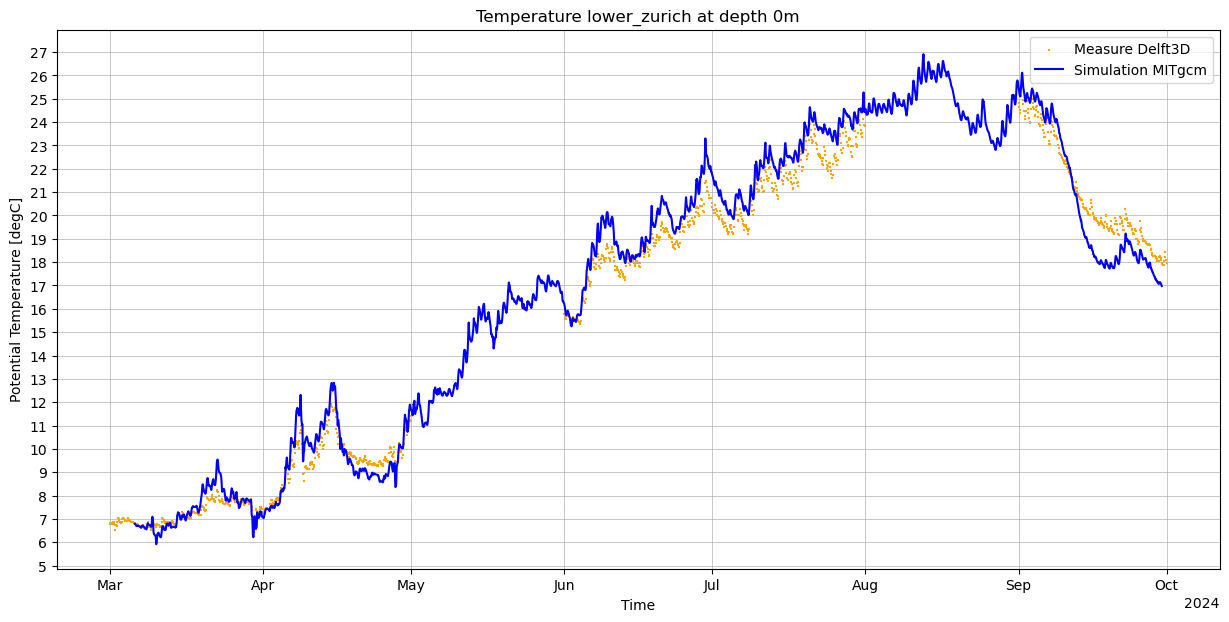

In [96]:
depth_plot=0 # Value should be negative !!

fig, ax = plt.subplots(1,1,figsize=(15, 7))

if xr_measure is not None:
    #meas_selected = xr_measure['temperature']#.sel(depth=depth_plot, method='nearest') #.sel(time=slice(start_date,end_date))
    plt.scatter(alplakes_timeseries['time'],alplakes_timeseries['temperature'],label=f'Measure Delft3D', marker='+', s=3, c='orange')

#simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date)).plot(label=f'Simstrat 1D', color='g')

sim_selected=ds_to_plot[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest') #.sel(time=slice(start_date, end_date))
sim_selected.plot(label='Simulation MITgcm', color='b')

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")

plt.savefig(rf"timeseries_{lake_name}_{depth_plot}m.png")

# Profile

In [52]:
print(df.columns[1:].to_list())

with open(f"data/alplakes_3d_profile_{sta_name}/{date_plot_profil_str}.json", 'r') as file:
    alplakes_json = json.load(file)
alplakes_profile = parse_alplakes_json_profile_to_df(alplakes_json)
#alplakes_profile

['03.01.2024', '07.02.2024', '06.03.2024', '03.04.2024', '07.05.2024', '05.06.2024', '03.07.2024', '07.08.2024', '04.09.2024', '09.10.2024', '06.11.2024', '04.12.2024']


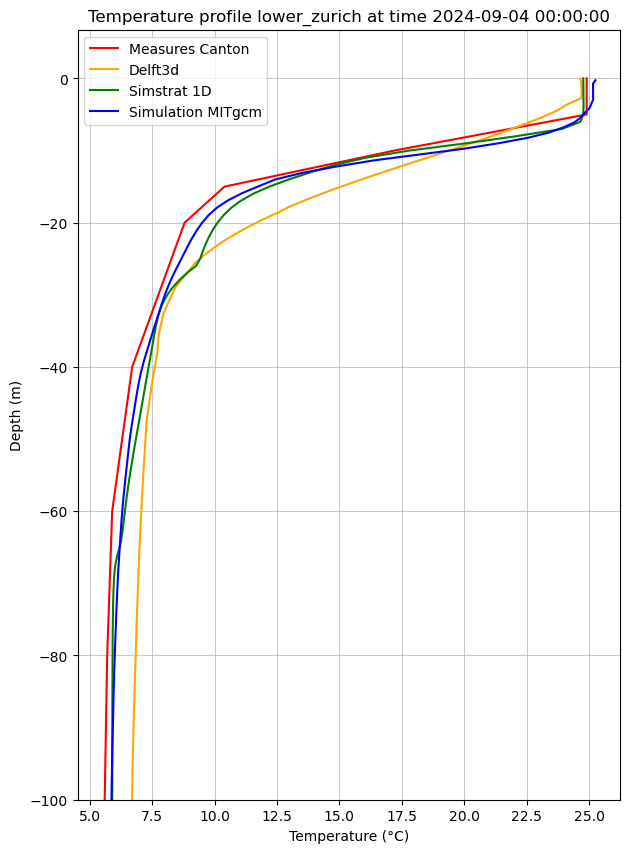

In [51]:
fig = plt.figure(figsize=(7, 10))

#meas_profile = xr_measure['temp'].sel(time=date_plot_profil, method='nearest')
#plt.plot(meas_profile.values, meas_profile.depth.values, label=f'Measure Idronaut', color='r')

# plot the xlsx format, just change the DATE
plt.plot(df['04.09.2024'],-1*df.Depth, label=f'Measures Canton', color='r')

plt.plot(alplakes_profile.temperature,-1*alplakes_profile.depth, label=f'Delft3d', color='orange')
# Convert Simstrat depth to negative and plot
simstrat_depth_negative = -simstrat_data['depth'].values  # Convert to negative NumPy array
simstrat_temperature = simstrat_data['temperature'].sel(time=date_plot_profil, method='nearest')
plt.plot(simstrat_temperature.values, simstrat_depth_negative, label='Simstrat 1D', color='g')


profile_to_plot = ds_to_plot['THETA'].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, time=date_plot_profil, method='nearest')
profile_to_plot.where(profile_to_plot != 0, np.nan).plot(y='Z', label='Simulation MITgcm', color='b')

plt.title(f"Temperature profile {sta_name} at time {date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.ylim(bottom=-100)
plt.xlabel('Temperature (°C)')
plt.legend()
plt.savefig(rf"{lake_name}_profile_{date_plot_profil.date()}_UTC.png")
plt.show()